<a href="https://colab.research.google.com/github/bvidimova/Data_analysis_spines/blob/main/Training_DeepD3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install deepd3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.0/961.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.4 MB/s eta 0:00:00


In [3]:
!pip install segmentation_models

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
# Neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
sm.set_framework("tf.keras")

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# DeepD3
from deepd3.model import DeepD3_Model
from deepd3.training.stream import DataGeneratorStream

## Load training data

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
TRAINING_DATA_PATH = '/content/drive/MyDrive/train.d3set'

dg_training = DataGeneratorStream(TRAINING_DATA_PATH,
                                  batch_size=2, # Data processed at once, depends on your GPU
                                  target_resolution=0.06, # fixed to 94 nm, can be None for mixed resolution training
                                  min_content=50) # images need to have at least 50 segmented px


In [8]:

VALIDATION_DATA_PATH = '/content/drive/MyDrive/validation.d3set'
dg_validation = DataGeneratorStream(VALIDATION_DATA_PATH,
                                    batch_size=2,
                                    target_resolution=0.06,
                                    min_content=50,
                                    augment=False,
                                    shuffle=False)

## Visualize data

Glancing on the data to verify that settings are as expected.

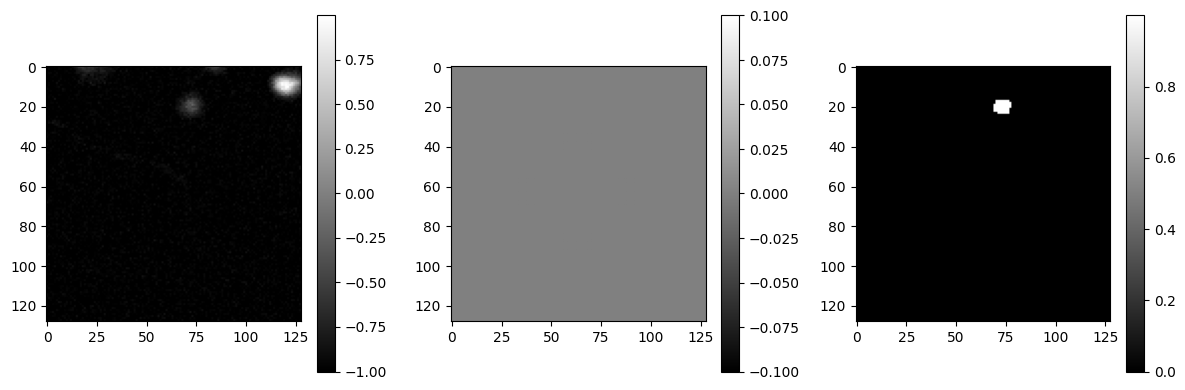

In [9]:
X, Y = dg_training[0]
i = 0

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(X[i].squeeze(), cmap='gray')
plt.colorbar()

plt.subplot(132)
plt.imshow(Y[0][i].squeeze(), cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.imshow(Y[1][i].squeeze(), cmap='gray')
plt.colorbar()

plt.tight_layout()

## Creating model and set training parameters

In [10]:
# Create a naive DeepD3 model with a given base filter count (e.g. 32)
m = DeepD3_Model(filters=32)

# Set appropriate training settings
m.compile(Adam(learning_rate=0.0005), # optimizer, good default setting, can be tuned
          [sm.losses.dice_loss, "mse"], # Dice loss for dendrite, MSE for spines
          metrics=['acc', sm.metrics.iou_score]) # Metrics for monitoring progress

m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 enc_layer0_conv1 (Conv2D)   (None, 128, 128, 32)         288       ['input[0][0]']               
                                                                                                  
 enc_layer0_conv1_BN (Batch  (None, 128, 128, 32)         128       ['enc_layer0_conv1[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 enc_layer0_conv1_activatio  (None, 128, 128, 32)         0         ['enc_layer0_conv1_BN[0][0

## Fitting model

Loading some training callbacks, such as adjusting the learning rate across time, saving training progress and intermediate models

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [12]:
def schedule(epoch, lr):
    if epoch < 15:
        return lr

    else:
        return lr * tf.math.exp(-0.1)

# Train your own DeepD3 model

In [13]:
EPOCHS = 10

# Save best model automatically during training
mc = ModelCheckpoint("DeepD3_model.h5",
                            save_best_only=False)

# Save metrics
csv = CSVLogger("DeepD3_model.csv")

# Adjust learning rate during training to allow for better convergence
lrs = LearningRateScheduler(schedule)

# Actually train the network
h = m.fit(dg_training,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=dg_validation,
        callbacks=[mc, csv, lrs])

Epoch 1/10
24998/25000 [============================>.] - ETA: 0s - loss: 0.2206 - dendrites_loss: 0.2147 - spines_loss: 0.0059 - dendrites_acc: 0.9018 - dendrites_iou_score: 0.6656 - spines_acc: 0.9838 - spines_iou_score: 0.3723

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25000/25000 [==============================] - 1005s 39ms/step - loss: 0.2206 - dendrites_loss: 0.2147 - spines_loss: 0.0059 - dendrites_acc: 0.9018 - dendrites_iou_score: 0.6656 - spines_acc: 0.9838 - spines_iou_score: 0.3723 - val_loss: 0.3752 - val_dendrites_loss: 0.3655 - val_spines_loss: 0.0098 - val_dendrites_acc: 0.9288 - val_dendrites_iou_score: 0.4925 - val_spines_acc: 0.9807 - val_spines_iou_score: 0.2835 - lr: 5.0000e-04
Epoch 2/10
25000/25000 [==============================] - 960s 38ms/step - loss: 0.1408 - dendrites_loss: 0.1379 - spines_loss: 0.0030 - dendrites_acc: 0.9080 - dendrites_iou_score: 0.7702 - spines_acc: 0.9850 - spines_iou_score: 0.5732 - val_loss: 0.3777 - val_dendrites_loss: 0.3671 - val_spines_loss: 0.0106 - val_dendrites_acc: 0.9263 - val_dendrites_iou_score: 0.4908 - val_spines_acc: 0.9817 - val_spines_iou_score: 0.2593 - lr: 5.0000e-04
Epoch 3/10
25000/25000 [==============================] - 961s 38ms/step - loss: 0.1127 - dendrites_loss: 0.1103 - spi

## Save model for use in GUI or batch processing

This is for saving the neural network manually. The best model is automatically saved during training.

In [14]:
m.save("deepd3_custom_trained_model.h5")